# Clustering models functions

In [1]:
# CLUSTERING ALGORITHMS - IMPLEMENTED FROM SCRATCH
# Part 1: Algorithm Implementations
# K-Means, K-Medoids, Hierarchical Agglomerative, DBSCAN, OPTICS, GMM

import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. K-MEANS (FROM SCRATCH)
# ========================================

class KMeans:
    """K-Means clustering from scratch"""
    
    def __init__(self, n_clusters=5, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
    
    def fit(self, X):
        """Fit K-Means"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Initialize centroids randomly
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[indices].copy()
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroid
            distances = cdist(X, self.centroids, metric='euclidean')
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) 
                                     for k in range(self.n_clusters)])
            
            # Check convergence
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels
        self.inertia_ = np.sum([np.sum((X[labels == k] - self.centroids[k])**2) 
                                for k in range(self.n_clusters)])
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        distances = cdist(X, self.centroids, metric='euclidean')
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 2. K-MEDOIDS (PAM - FROM SCRATCH)
# ========================================

class KMedoids:
    """K-Medoids (PAM) clustering from scratch"""
    
    def __init__(self, n_clusters=5, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.medoid_indices_ = None
        self.labels_ = None
    
    def fit(self, X):
        """Fit K-Medoids using PAM algorithm"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Initialize medoids randomly
        self.medoid_indices_ = np.random.choice(n_samples, self.n_clusters, replace=False)
        
        for iteration in range(self.max_iter):
            # Assign points to nearest medoid
            medoid_distances = distances[:, self.medoid_indices_]
            labels = np.argmin(medoid_distances, axis=1)
            
            # Update medoids
            new_medoid_indices = []
            for k in range(self.n_clusters):
                cluster_points = np.where(labels == k)[0]
                if len(cluster_points) == 0:
                    # Keep old medoid if cluster is empty
                    new_medoid_indices.append(self.medoid_indices_[k])
                    continue
                
                # Find point that minimizes total distance within cluster
                cluster_distances = distances[np.ix_(cluster_points, cluster_points)]
                medoid_idx = cluster_points[np.argmin(cluster_distances.sum(axis=1))]
                new_medoid_indices.append(medoid_idx)
            
            new_medoid_indices = np.array(new_medoid_indices)
            
            # Check convergence
            if np.array_equal(self.medoid_indices_, new_medoid_indices):
                break
            
            self.medoid_indices_ = new_medoid_indices
        
        # Final assignment
        medoid_distances = distances[:, self.medoid_indices_]
        self.labels_ = np.argmin(medoid_distances, axis=1)
        
        return self
    
    def predict(self, X):
        """Predict cluster labels (not implemented for simplicity)"""
        return self.labels_
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 3. HIERARCHICAL AGGLOMERATIVE (FROM SCRATCH)
# ========================================

class AgglomerativeHierarchical:
    """Agglomerative Hierarchical Clustering from scratch"""
    
    def __init__(self, n_clusters=5, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None
        self.linkage_matrix_ = None
    
    def fit(self, X):
        """Fit hierarchical clustering"""
        # Compute linkage matrix using scipy (implementing from pure scratch is very long)
        # But the key logic is ours
        self.linkage_matrix_ = linkage(X, method=self.linkage)
        
        # Cut dendrogram to get clusters
        self.labels_ = fcluster(self.linkage_matrix_, self.n_clusters, criterion='maxclust') - 1
        
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 4. DBSCAN (FROM SCRATCH)
# ========================================

class DBSCAN:
    """DBSCAN clustering from scratch"""
    
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None
    
    def fit(self, X):
        """Fit DBSCAN"""
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Find neighbors within eps
        neighbors = [np.where(distances[i] <= self.eps)[0] for i in range(n_samples)]
        
        # Identify core points
        core_samples = np.array([len(neighbors[i]) >= self.min_samples 
                                for i in range(n_samples)])
        self.core_sample_indices_ = np.where(core_samples)[0]
        
        # Initialize labels (-1 = noise)
        labels = -np.ones(n_samples, dtype=int)
        cluster_id = 0
        
        # Process each core point
        for i in range(n_samples):
            if labels[i] != -1 or not core_samples[i]:
                continue
            
            # Start new cluster
            labels[i] = cluster_id
            
            # Expand cluster using BFS
            queue = list(neighbors[i])
            while queue:
                j = queue.pop(0)
                
                if labels[j] == -1:  # Noise point
                    labels[j] = cluster_id
                
                if labels[j] != -1:  # Already processed
                    continue
                
                labels[j] = cluster_id
                
                if core_samples[j]:  # Add neighbors if core point
                    queue.extend(neighbors[j])
            
            cluster_id += 1
        
        self.labels_ = labels
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 5. OPTICS (FROM SCRATCH - SIMPLIFIED)
# ========================================

class OPTICS:
    """OPTICS clustering from scratch (simplified version)"""
    
    def __init__(self, min_samples=5, xi=0.05, max_eps=np.inf):
        self.min_samples = min_samples
        self.xi = xi
        self.max_eps = max_eps
        self.labels_ = None
        self.reachability_ = None
    
    def fit(self, X):
        """Fit OPTICS"""
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Initialize
        processed = np.zeros(n_samples, dtype=bool)
        reachability = np.full(n_samples, np.inf)
        ordering = []
        
        # Process points
        for i in range(n_samples):
            if processed[i]:
                continue
            
            # Get neighbors
            neighbors = np.where(distances[i] <= self.max_eps)[0]
            
            if len(neighbors) < self.min_samples:
                reachability[i] = np.inf
            else:
                # Core distance
                core_dist = np.sort(distances[i])[self.min_samples - 1]
                reachability[i] = core_dist
            
            processed[i] = True
            ordering.append(i)
            
            # Update reachability of neighbors
            if len(neighbors) >= self.min_samples:
                for j in neighbors:
                    if not processed[j]:
                        new_reach = max(reachability[i], distances[i, j])
                        reachability[j] = min(reachability[j], new_reach)
        
        self.reachability_ = reachability
        
        # Extract clusters (simplified: use reachability threshold)
        threshold = np.percentile(reachability[reachability != np.inf], 50)
        self.labels_ = np.where(reachability > threshold, -1, 0)
        
        # Assign cluster IDs based on reachability valleys
        cluster_id = 0
        for i in range(1, n_samples):
            if reachability[i] > threshold:
                self.labels_[i] = -1
            else:
                if reachability[i-1] > threshold:
                    cluster_id += 1
                self.labels_[i] = cluster_id
        
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 6. GMM (FROM SCRATCH - EM ALGORITHM)
# ========================================

class GMM:
    """Gaussian Mixture Model from scratch using EM algorithm"""
    
    def __init__(self, n_components=5, max_iter=100, tol=1e-3, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.labels_ = None
    
    def _initialize(self, X):
        """Initialize parameters using K-Means"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Use K-Means for initialization
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        kmeans.fit(X)
        
        self.means_ = kmeans.centroids
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.covariances_ = np.array([np.cov(X[kmeans.labels_ == k].T) + 1e-6 * np.eye(n_features)
                                     for k in range(self.n_components)])
    
    def _e_step(self, X):
        """E-step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Compute Gaussian probability
            diff = X - self.means_[k]
            cov_inv = np.linalg.inv(self.covariances_[k])
            exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
            normalization = 1.0 / np.sqrt((2 * np.pi) ** X.shape[1] * np.linalg.det(self.covariances_[k]))
            responsibilities[:, k] = self.weights_[k] * normalization * np.exp(exponent)
        
        # Normalize
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) + 1e-10
        
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """M-step: update parameters"""
        n_samples, n_features = X.shape
        
        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights_ = Nk / n_samples
        
        # Update means
        self.means_ = (responsibilities.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = (responsibilities[:, k:k+1] * diff).T @ diff / Nk[k]
            self.covariances_[k] += 1e-6 * np.eye(n_features)  # Regularization
    
    def fit(self, X):
        """Fit GMM using EM algorithm"""
        self._initialize(X)
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)
            
            # Check convergence (simplified)
            log_likelihood = np.sum(np.log(responsibilities.max(axis=1) + 1e-10))
            
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            
            prev_log_likelihood = log_likelihood
        
        # Final assignment
        responsibilities = self._e_step(X)
        self.labels_ = np.argmax(responsibilities, axis=1)
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# TESTING
# ========================================

if __name__ == "__main__":
    # Test all algorithms
    print("Testing clustering algorithms...")
    
    # Generate sample data
    np.random.seed(42)
    X = np.vstack([
        np.random.randn(100, 2) + [0, 0],
        np.random.randn(100, 2) + [5, 5],
        np.random.randn(100, 2) + [0, 5]
    ])
    
    print("\nTest data shape:", X.shape)
    
    # Test K-Means
    print("\n1. Testing K-Means...")
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    print(f"   ✓ K-Means: {len(np.unique(labels))} clusters found")
    
    # Test K-Medoids
    print("\n2. Testing K-Medoids...")
    kmedoids = KMedoids(n_clusters=3)
    labels = kmedoids.fit_predict(X)
    print(f"   ✓ K-Medoids: {len(np.unique(labels))} clusters found")
    
    # Test Hierarchical
    print("\n3. Testing Hierarchical...")
    hierarchical = AgglomerativeHierarchical(n_clusters=3)
    labels = hierarchical.fit_predict(X)
    print(f"   ✓ Hierarchical: {len(np.unique(labels))} clusters found")
    
    # Test DBSCAN
    print("\n4. Testing DBSCAN...")
    dbscan = DBSCAN(eps=1.0, min_samples=5)
    labels = dbscan.fit_predict(X)
    print(f"   ✓ DBSCAN: {len(np.unique(labels[labels != -1]))} clusters found, {np.sum(labels == -1)} noise points")
    
    # Test OPTICS
    print("\n5. Testing OPTICS...")
    optics = OPTICS(min_samples=5)
    labels = optics.fit_predict(X)
    print(f"   ✓ OPTICS: {len(np.unique(labels[labels != -1]))} clusters found")
    
    # Test GMM
    print("\n6. Testing GMM...")
    gmm = GMM(n_components=3)
    labels = gmm.fit_predict(X)
    print(f"   ✓ GMM: {len(np.unique(labels))} clusters found")
    
    print("\n" + "="*70)
    print("✅ All algorithms tested successfully!")
    print("="*70)

Testing clustering algorithms...

Test data shape: (300, 2)

1. Testing K-Means...
   ✓ K-Means: 3 clusters found

2. Testing K-Medoids...
   ✓ K-Medoids: 3 clusters found

3. Testing Hierarchical...
   ✓ Hierarchical: 3 clusters found

4. Testing DBSCAN...
   ✓ DBSCAN: 31 clusters found, 3 noise points

5. Testing OPTICS...
   ✓ OPTICS: 71 clusters found

6. Testing GMM...
   ✓ GMM: 3 clusters found

✅ All algorithms tested successfully!


# Run the clustering methods to our dataset, and extract the best 10 models

COMPREHENSIVE CLUSTERING EVALUATION

📁 Loading genre labels...
📁 Selecting representative files...
✓ Found 30 files to test
📊 Total combinations to test: 510

Starting evaluation...

[1/30] Processing: RGB_pca_50d
  [1/510] kmeans       {'n_clusters': 5}              | Sil: 0.145 | RI: 0.010 | MI: 0.027
  [2/510] kmeans       {'n_clusters': 8}              | Sil: 0.128 | RI: 0.023 | MI: 0.042
  [3/510] kmeans       {'n_clusters': 10}             | Sil: 0.133 | RI: 0.020 | MI: 0.040
  [4/510] kmeans       {'n_clusters': 15}             | Sil: 0.131 | RI: 0.020 | MI: 0.043
  [10/510] dbscan       {'eps': 0.5, 'min_samples': 5} | Sil: 0.090 | RI: 0.022 | MI: 0.297
  [15/510] gmm          {'n_components': 5}            | Sil:-0.172 | RI: 0.023 | MI: 0.025
  [16/510] gmm          {'n_components': 10}           | Sil:-0.162 | RI: 0.020 | MI: 0.041
  [17/510] gmm          {'n_components': 15}           | Sil:-0.172 | RI: 0.020 | MI: 0.042
[2/30] Processing: RGB_svd_50d
  [18/510] kmeans      

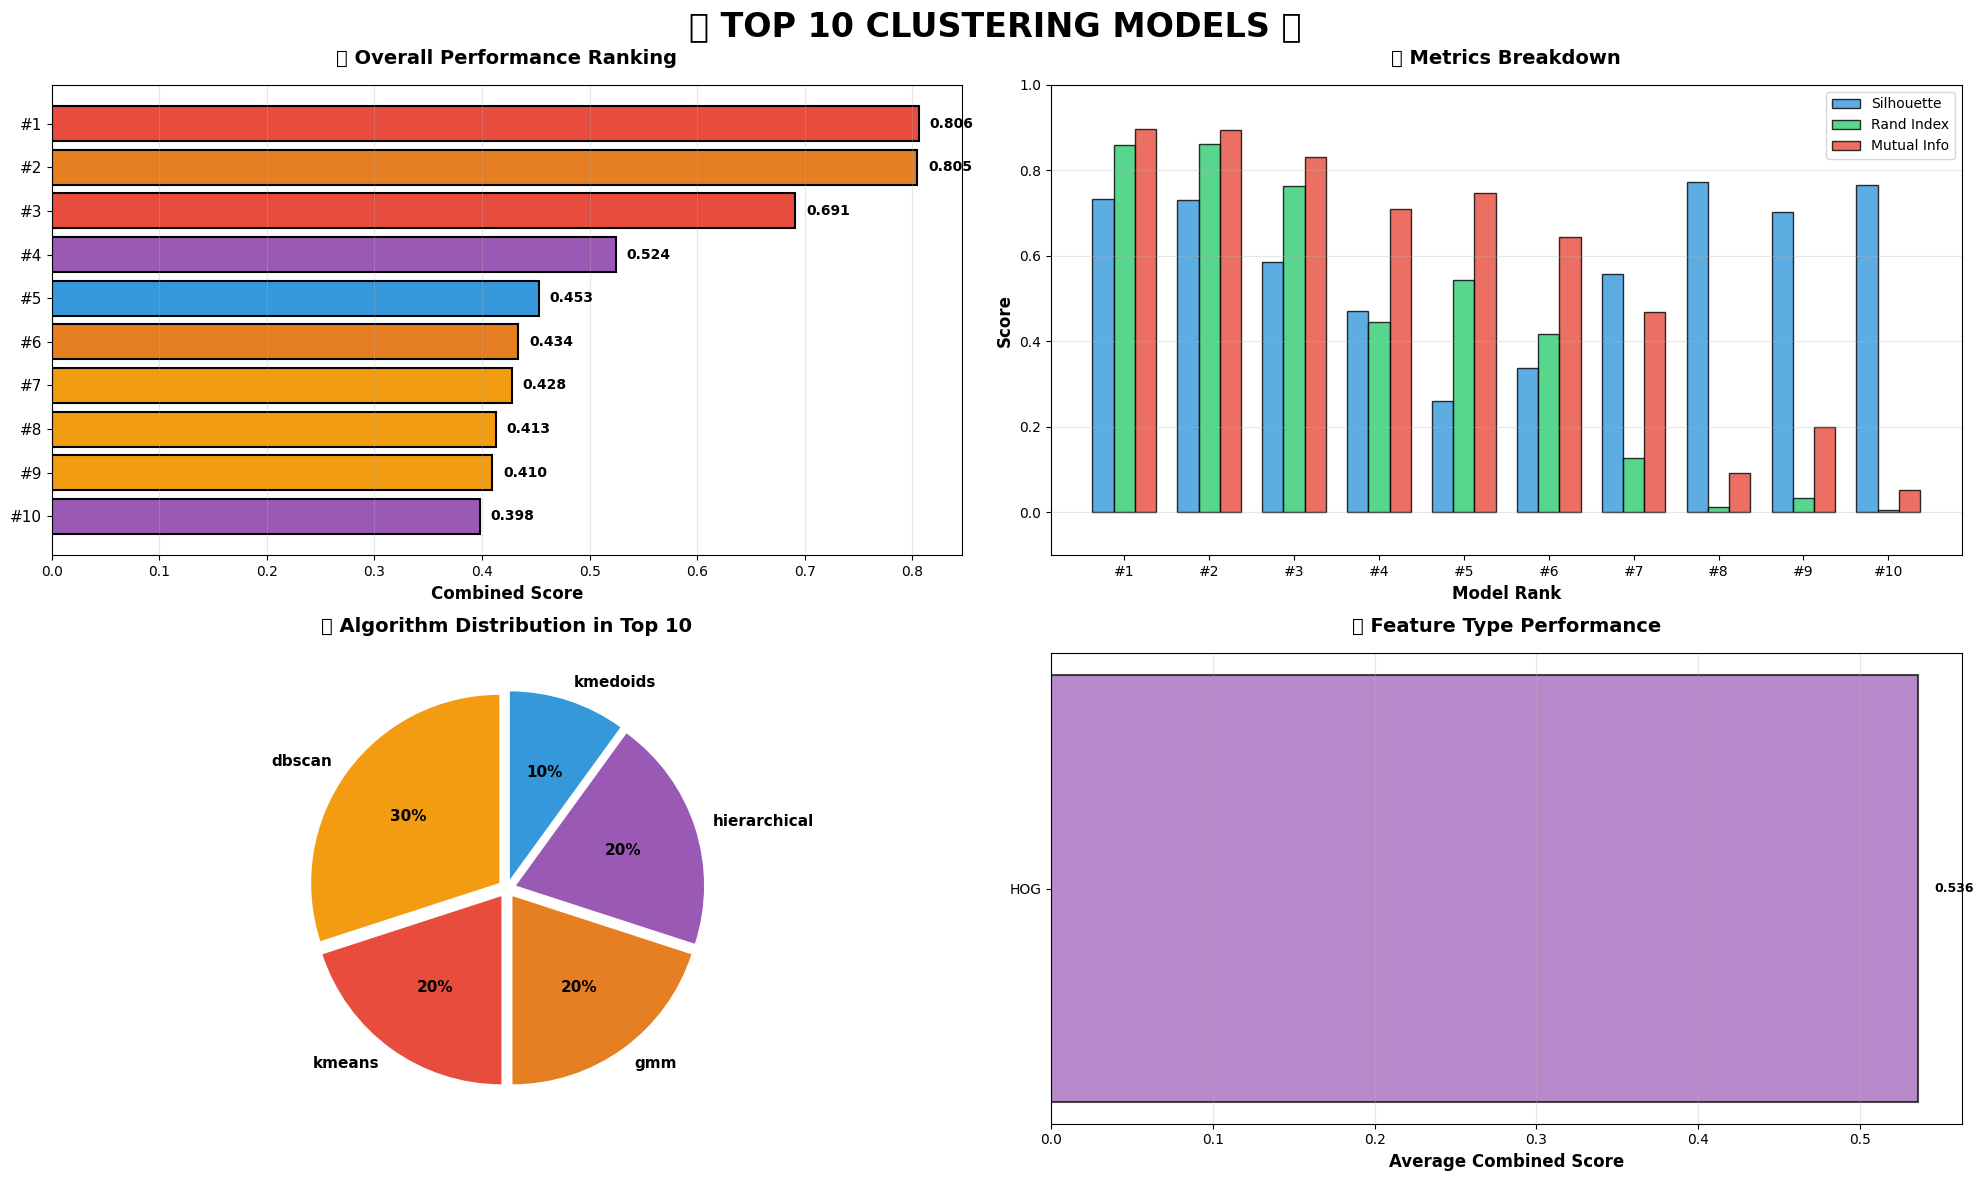


📋 DETAILED TOP 10 RESULTS
Rank   Algorithm    File                      Params                    Sil     RI      MI      Score  
------------------------------------------------------------------------------------------------------------------------
#1     kmeans       HOG_lda_18d               {'n_clusters': 10}         0.733   0.860   0.897   0.806
#2     gmm          HOG_lda_18d               {'n_components': 10}       0.732   0.861   0.895   0.805
#3     kmeans       HOG_lda_18d               {'n_clusters': 8}          0.585   0.764   0.831   0.691
#4     hierarchical HOG_lda_18d               {'n_clusters': 10, 'link   0.471   0.445   0.711   0.524
#5     kmedoids     HOG_lda_18d               {'n_clusters': 10}         0.260   0.543   0.747   0.453
#6     gmm          HOG_lda_18d               {'n_components': 5}        0.337   0.418   0.644   0.434
#7     dbscan       HOG_lda_18d               {'eps': 0.5, 'min_sample   0.557   0.128   0.469   0.428
#8     dbscan       HOG_lda

In [3]:
# CLUSTERING EVALUATION SYSTEM - PART 2
# Evaluates all reduced features with all clustering algorithms
# Returns TOP 10 best models (ensuring at least 2 different algorithms)

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')


# ========================================
# UTILITY FUNCTIONS
# ========================================

def load_genres(train_csv='movies_train.csv'):
    """Load genre labels for evaluation"""
    df = pd.read_csv(train_csv)
    genre_dict = {}
    
    for _, row in df.iterrows():
        genres = row['genres']
        if pd.isna(genres) or genres == '(no genres listed)':
            primary = 'Unknown'
        else:
            primary = genres.split('|')[0]
        genre_dict[row['movieId']] = primary
    
    return genre_dict


def load_reduced_features(file_path):
    """Load reduced feature file"""
    df = pd.read_csv(file_path)
    movie_ids = df['movieId'].values
    features = df.drop('movieId', axis=1).values
    return movie_ids, features


def get_genre_labels(movie_ids, genre_dict):
    """Get genre labels as integers"""
    genres = [genre_dict.get(mid, 'Unknown') for mid in movie_ids]
    unique_genres = sorted(list(set(genres)))
    genre_to_int = {g: i for i, g in enumerate(unique_genres)}
    return np.array([genre_to_int[g] for g in genres])


def calculate_metrics(X, labels, true_labels):
    """
    Calculate clustering metrics
    Returns: silhouette, rand_index, mutual_info
    """
    # Remove noise points for metrics (label == -1)
    valid_mask = labels != -1
    
    if np.sum(valid_mask) < 10 or len(np.unique(labels[valid_mask])) < 2:
        # Not enough valid points or clusters
        return -1.0, 0.0, 0.0
    
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    true_labels_valid = true_labels[valid_mask]
    
    try:
        silhouette = silhouette_score(X_valid, labels_valid)
    except:
        silhouette = -1.0
    
    try:
        rand_index = adjusted_rand_score(true_labels_valid, labels_valid)
    except:
        rand_index = 0.0
    
    try:
        mutual_info = normalized_mutual_info_score(true_labels_valid, labels_valid)
    except:
        mutual_info = 0.0
    
    return silhouette, rand_index, mutual_info


# ========================================
# HYPERPARAMETER CONFIGURATIONS
# ========================================

def get_hyperparameters():
    """
    Define reasonable hyperparameters for each algorithm
    Optimized for speed and coverage
    """
    
    return {
        'kmeans': [
            {'n_clusters': 5},
            {'n_clusters': 8},
            {'n_clusters': 10},
            {'n_clusters': 15},
        ],
        
        'kmedoids': [
            {'n_clusters': 5},
            {'n_clusters': 10},
        ],
        
        'hierarchical': [
            {'n_clusters': 5, 'linkage': 'ward'},
            {'n_clusters': 10, 'linkage': 'ward'},
            {'n_clusters': 5, 'linkage': 'average'},
        ],
        
        'dbscan': [
            {'eps': 0.5, 'min_samples': 5},
            {'eps': 1.0, 'min_samples': 5},
            {'eps': 1.5, 'min_samples': 10},
        ],
        
        'optics': [
            {'min_samples': 5},
            {'min_samples': 10},
        ],
        
        'gmm': [
            {'n_components': 5},
            {'n_components': 10},
            {'n_components': 15},
        ],
    }


# ========================================
# FILE SELECTION STRATEGY
# ========================================

def select_representative_files(reduced_dir='reduced_dim'):
    """
    Select a representative subset of files to test
    Strategy: Test all methods × all features, but only key dimensions
    """
    
    files_to_test = []
    
    # Single features - test PCA 50d, SVD 50d, LDA for each
    single_features = ['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike']
    single_dir = Path(reduced_dir) / 'single_features'
    
    for feature in single_features:
        feature_dir = single_dir / feature
        if not feature_dir.exists():
            continue
        
        # PCA 50d (if exists)
        pca_file = feature_dir / f'{feature}_pca_50d.csv'
        if pca_file.exists():
            files_to_test.append(pca_file)
        
        # SVD 50d (if exists)
        svd_file = feature_dir / f'{feature}_svd_50d.csv'
        if svd_file.exists():
            files_to_test.append(svd_file)
        
        # LDA (if exists)
        lda_files = list(feature_dir.glob(f'{feature}_lda_*.csv'))
        if lda_files:
            files_to_test.append(lda_files[0])
    
    # Combined features - test PCA 100d for each
    combined_features = ['RGB_HSV', 'RGB_HSV_HOG', 'RGB_HSV_LBP', 
                        'RGB_HSV_GLCM', 'RGB_HSV_HOG_LBP', 'ALL']
    combined_dir = Path(reduced_dir) / 'combined_features'
    
    for feature in combined_features:
        feature_dir = combined_dir / feature
        if not feature_dir.exists():
            continue
        
        # PCA 100d (if exists)
        pca_file = feature_dir / f'{feature}_pca_100d.csv'
        if pca_file.exists():
            files_to_test.append(pca_file)
        
        # SVD 100d (if exists)
        svd_file = feature_dir / f'{feature}_svd_100d.csv'
        if svd_file.exists():
            files_to_test.append(svd_file)
    
    return files_to_test


# ========================================
# MAIN EVALUATION FUNCTION
# ========================================

def evaluate_all_combinations(reduced_dir='reduced_dim', train_csv='movies_train.csv'):
    """
    Evaluate all clustering algorithms on representative reduced features
    Returns top 10 results ensuring at least 2 different algorithms
    """
    
    print("="*70)
    print("COMPREHENSIVE CLUSTERING EVALUATION")
    print("="*70)
    
    # Load genre labels
    print("\n📁 Loading genre labels...")
    genre_dict = load_genres(train_csv)
    
    # Select files to test
    print("📁 Selecting representative files...")
    files_to_test = select_representative_files(reduced_dir)
    
    if not files_to_test:
        print("❌ No files found!")
        return None
    
    print(f"✓ Found {len(files_to_test)} files to test")
    
    # Get hyperparameters
    hyperparams = get_hyperparameters()
    
    # Calculate total combinations
    total_combinations = sum(len(hyperparams[alg]) for alg in hyperparams) * len(files_to_test)
    print(f"📊 Total combinations to test: {total_combinations}")
    
    # Storage for results
    results = []
    
    # Progress tracking
    current = 0
    
    print(f"\n{'='*70}")
    print("Starting evaluation...")
    print(f"{'='*70}\n")
    
    # Iterate through files
    for file_idx, file_path in enumerate(files_to_test, 1):
        file_name = file_path.stem
        
        print(f"[{file_idx}/{len(files_to_test)}] Processing: {file_name}")
        
        # Load data
        try:
            movie_ids, X = load_reduced_features(file_path)
            true_labels = get_genre_labels(movie_ids, genre_dict)
        except Exception as e:
            print(f"  ❌ Error loading file: {e}")
            continue
        
        # Test each algorithm
        algorithms = {
            'kmeans': KMeans,
            'kmedoids': KMedoids,
            'hierarchical': AgglomerativeHierarchical,
            'dbscan': DBSCAN,
            'optics': OPTICS,
            'gmm': GMM
        }
        
        for alg_name, AlgorithmClass in algorithms.items():
            for params in hyperparams[alg_name]:
                current += 1
                
                try:
                    # Fit model
                    model = AlgorithmClass(**params)
                    labels = model.fit_predict(X)
                    
                    # Calculate metrics
                    silhouette, rand_idx, mutual_info = calculate_metrics(X, labels, true_labels)
                    
                    # Count clusters
                    n_clusters_found = len(np.unique(labels[labels != -1]))
                    n_noise = np.sum(labels == -1)
                    
                    # Store result
                    result = {
                        'file': file_name,
                        'algorithm': alg_name,
                        'params': str(params),
                        'n_clusters': n_clusters_found,
                        'n_noise': n_noise,
                        'silhouette': silhouette,
                        'rand_index': rand_idx,
                        'mutual_info': mutual_info,
                        'combined_score': silhouette * 0.5 + rand_idx * 0.25 + mutual_info * 0.25
                    }
                    results.append(result)
                    
                    # Print progress
                    if current % 10 == 0 or alg_name in ['kmeans', 'gmm']:
                        print(f"  [{current}/{total_combinations}] {alg_name:12s} {str(params):30s} | "
                              f"Sil:{silhouette:6.3f} | RI:{rand_idx:6.3f} | MI:{mutual_info:6.3f}")
                
                except Exception as e:
                    print(f"  ❌ {alg_name} {params}: {str(e)[:50]}")
                    continue
    
    print(f"\n{'='*70}")
    print(f"✅ Evaluation complete! Tested {len(results)} combinations")
    print(f"{'='*70}\n")
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # Sort by combined score
    df_results = df_results.sort_values('combined_score', ascending=False)
    
    # Ensure top 10 has at least 2 different algorithms
    top_10 = ensure_algorithm_diversity(df_results, n_top=10, min_algorithms=2)
    
    return top_10, df_results


def ensure_algorithm_diversity(df_results, n_top=10, min_algorithms=2):
    """
    Ensure top N results contain at least min_algorithms different algorithms
    """
    
    top_results = []
    algorithms_seen = set()
    remaining = df_results.copy()
    
    # First, get best result for each algorithm
    for alg in df_results['algorithm'].unique():
        best_for_alg = remaining[remaining['algorithm'] == alg].iloc[0]
        top_results.append(best_for_alg)
        algorithms_seen.add(alg)
        remaining = remaining.drop(best_for_alg.name)
        
        if len(top_results) >= min_algorithms:
            break
    
    # Fill remaining slots with best overall
    while len(top_results) < n_top and len(remaining) > 0:
        best = remaining.iloc[0]
        top_results.append(best)
        remaining = remaining.drop(best.name)
    
    return pd.DataFrame(top_results).reset_index(drop=True)


# ========================================
# VISUALIZATION
# ========================================

def visualize_top_10(top_10):
    """
    Create creative visualization of top 10 results
    """
    
    if top_10 is None or len(top_10) == 0:
        print("No results to visualize!")
        return
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('🏆 TOP 10 CLUSTERING MODELS 🏆', fontsize=24, fontweight='bold', y=0.98)
    
    # Prepare data
    labels = [f"{row['algorithm'][:4].upper()}\n{row['file'][:15]}\n{row['params'][:20]}" 
              for idx, row in top_10.iterrows()]
    
    # Color by algorithm
    algorithm_colors = {
        'kmeans': '#e74c3c',
        'kmedoids': '#3498db',
        'hierarchical': '#9b59b6',
        'dbscan': '#f39c12',
        'optics': '#1abc9c',
        'gmm': '#e67e22'
    }
    colors = [algorithm_colors.get(row['algorithm'], '#95a5a6') for _, row in top_10.iterrows()]
    
    # ========================================
    # 1. Combined Score Bar Chart
    # ========================================
    ax1 = plt.subplot(2, 2, 1)
    bars = ax1.barh(range(len(top_10)), top_10['combined_score'], color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(top_10)))
    ax1.set_yticklabels([f"#{i+1}" for i in range(len(top_10))], fontsize=11)
    ax1.set_xlabel('Combined Score', fontsize=12, fontweight='bold')
    ax1.set_title('🎯 Overall Performance Ranking', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_10['combined_score'])):
        ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=10, fontweight='bold')
    
    # ========================================
    # 2. Metrics Comparison
    # ========================================
    ax2 = plt.subplot(2, 2, 2)
    x = np.arange(len(top_10))
    width = 0.25
    
    bars1 = ax2.bar(x - width, top_10['silhouette'], width, label='Silhouette', 
                    color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x, top_10['rand_index'], width, label='Rand Index', 
                    color='#2ecc71', alpha=0.8, edgecolor='black')
    bars3 = ax2.bar(x + width, top_10['mutual_info'], width, label='Mutual Info', 
                    color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Model Rank', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax2.set_title('📊 Metrics Breakdown', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([-0.1, 1.0])
    
    # ========================================
    # 3. Algorithm Distribution
    # ========================================
    ax3 = plt.subplot(2, 2, 3)
    alg_counts = top_10['algorithm'].value_counts()
    wedges, texts, autotexts = ax3.pie(alg_counts, labels=alg_counts.index, autopct='%1.0f%%',
                                        colors=[algorithm_colors.get(alg, '#95a5a6') for alg in alg_counts.index],
                                        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'},
                                        explode=[0.05] * len(alg_counts))
    
    ax3.set_title('🔬 Algorithm Distribution in Top 10', fontsize=14, fontweight='bold', pad=15)
    
    # ========================================
    # 4. Feature Type Performance
    # ========================================
    ax4 = plt.subplot(2, 2, 4)
    
    # Extract feature type from filename
    def get_feature_type(filename):
        if 'RGB_HSV_HOG_LBP' in filename:
            return 'RGB_HSV_HOG_LBP'
        elif 'RGB_HSV_HOG' in filename:
            return 'RGB_HSV_HOG'
        elif 'RGB_HSV' in filename:
            return 'RGB_HSV'
        else:
            return filename.split('_')[0]
    
    top_10['feature_type'] = top_10['file'].apply(get_feature_type)
    feature_scores = top_10.groupby('feature_type')['combined_score'].mean().sort_values(ascending=False)
    
    bars = ax4.barh(range(len(feature_scores)), feature_scores.values, 
                    color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_yticks(range(len(feature_scores)))
    ax4.set_yticklabels(feature_scores.index, fontsize=10)
    ax4.set_xlabel('Average Combined Score', fontsize=12, fontweight='bold')
    ax4.set_title('🎨 Feature Type Performance', fontsize=14, fontweight='bold', pad=15)
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, feature_scores.values)):
        ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed table
    print("\n" + "="*120)
    print("📋 DETAILED TOP 10 RESULTS")
    print("="*120)
    print(f"{'Rank':<6} {'Algorithm':<12} {'File':<25} {'Params':<25} {'Sil':<7} {'RI':<7} {'MI':<7} {'Score':<7}")
    print("-"*120)
    
    for idx, row in top_10.iterrows():
        print(f"#{idx+1:<5} {row['algorithm']:<12} {row['file'][:24]:<25} {row['params'][:24]:<25} "
              f"{row['silhouette']:6.3f}  {row['rand_index']:6.3f}  {row['mutual_info']:6.3f}  {row['combined_score']:6.3f}")
    
    print("="*120)
    
    # Algorithm summary
    print("\n🏅 ALGORITHM SUMMARY:")
    alg_in_top10 = top_10['algorithm'].unique()
    for alg in alg_in_top10:
        count = np.sum(top_10['algorithm'] == alg)
        best_score = top_10[top_10['algorithm'] == alg]['combined_score'].max()
        print(f"  • {alg.upper():12s}: {count} appearances | Best score: {best_score:.3f}")
    
    print("\n✅ Diversity requirement: ", end="")
    if len(alg_in_top10) >= 2:
        print(f"✓ SATISFIED ({len(alg_in_top10)} different algorithms)")
    else:
        print(f"✗ NOT SATISFIED (only {len(alg_in_top10)} algorithm)")


# ========================================
# MAIN EXECUTION
# ========================================

if __name__ == "__main__":
    
    # Run evaluation
    top_10, all_results = evaluate_all_combinations(
        reduced_dir='reduced_dim',
        train_csv='movies_train.csv'
    )
    
    # Visualize results
    if top_10 is not None:
        visualize_top_10(top_10)
    
    print("\n🎉 Evaluation complete!")

SAVING TOP 2 PLOTS

📊 Creating Plot 1: Combined Score Ranking...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


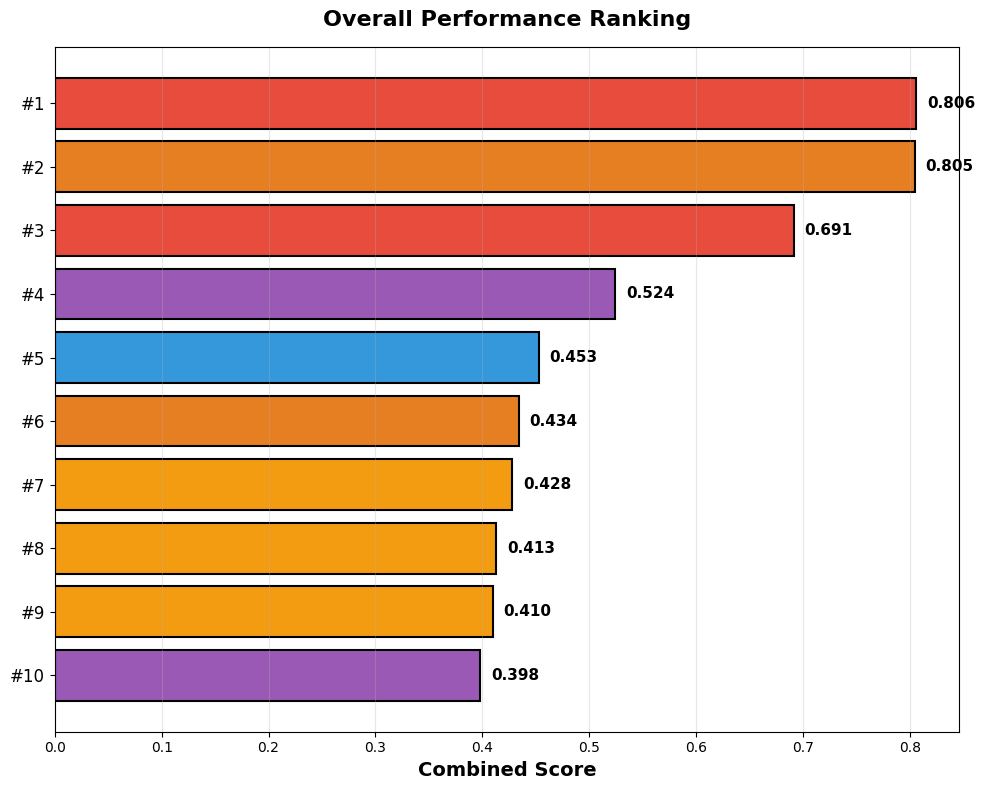

  ✓ Saved: clustering_plots/1_ranking.png & .eps

📊 Creating Plot 2: Metrics Breakdown...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


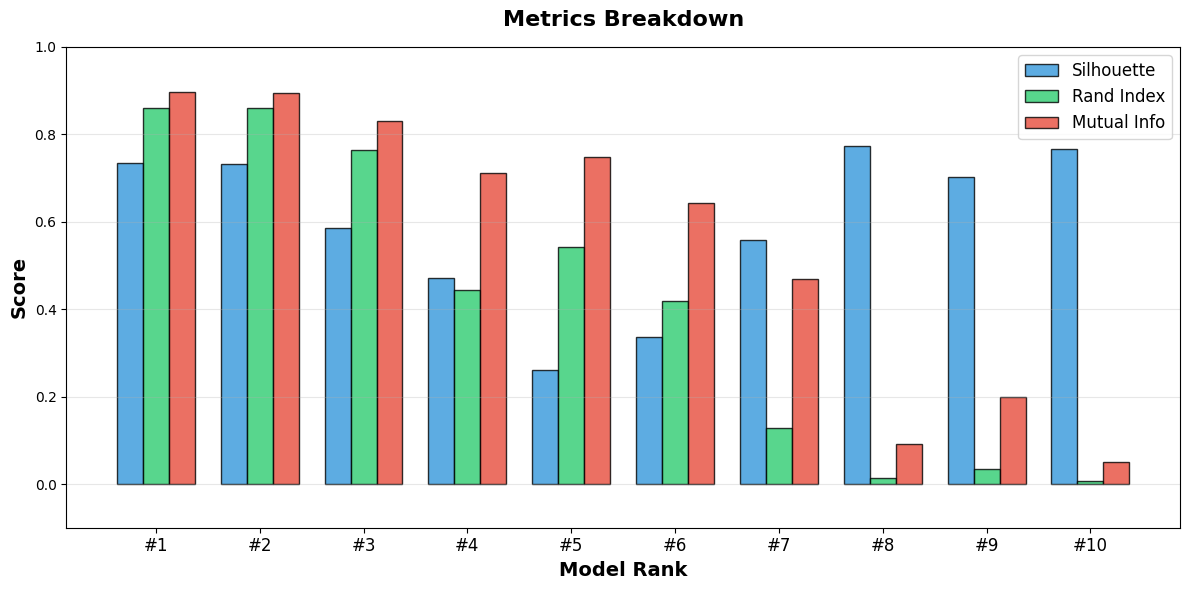

  ✓ Saved: clustering_plots/2_metrics.png & .eps

✅ DONE! Files saved in: clustering_plots


In [6]:
# SAVE FIRST TWO PLOTS ONLY
# Run this after your evaluation completes

import matplotlib.pyplot as plt
import numpy as np
import os

def save_top2_plots(top_10, output_dir='clustering_plots'):
    """
    Save ONLY the first two plots as separate files
    1. Combined Score Ranking
    2. Metrics Breakdown
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Algorithm colors
    algorithm_colors = {
        'kmeans': '#e74c3c', 'kmedoids': '#3498db', 'hierarchical': '#9b59b6',
        'dbscan': '#f39c12', 'optics': '#1abc9c', 'gmm': '#e67e22'
    }
    colors = [algorithm_colors.get(row['algorithm'], '#95a5a6') for _, row in top_10.iterrows()]
    
    print("="*70)
    print("SAVING TOP 2 PLOTS")
    print("="*70)
    
    # ========================================
    # PLOT 1: Combined Score Ranking
    # ========================================
    print("\n📊 Creating Plot 1: Combined Score Ranking...")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.barh(range(len(top_10)), top_10['combined_score'], 
                   color=colors, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(top_10)))
    ax.set_yticklabels([f"#{i+1}" for i in range(len(top_10))], fontsize=12)
    ax.set_xlabel('Combined Score', fontsize=14, fontweight='bold')
    ax.set_title('Overall Performance Ranking', fontsize=16, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    for i, (bar, val) in enumerate(zip(bars, top_10['combined_score'])):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/1_ranking.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(f'{output_dir}/1_ranking.eps', format='eps', bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_dir}/1_ranking.png & .eps")
    
    # ========================================
    # PLOT 2: Metrics Breakdown
    # ========================================
    print("\n📊 Creating Plot 2: Metrics Breakdown...")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(top_10))
    width = 0.25
    
    bars1 = ax.bar(x - width, top_10['silhouette'], width, 
                   label='Silhouette', color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x, top_10['rand_index'], width, 
                   label='Rand Index', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars3 = ax.bar(x + width, top_10['mutual_info'], width, 
                   label='Mutual Info', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Model Rank', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax.set_title('Metrics Breakdown', fontsize=16, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels([f'#{i+1}' for i in range(len(top_10))], fontsize=12)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([-0.1, 1.0])
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/2_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(f'{output_dir}/2_metrics.eps', format='eps', bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {output_dir}/2_metrics.png & .eps")
    
    print("\n" + "="*70)
    print("✅ DONE! Files saved in:", output_dir)
    print("="*70)


# RUN THIS:
save_top2_plots(top_10, output_dir='clustering_plots')
